<a href="https://colab.research.google.com/github/ChristopherHamian/Coursera_Capstone/blob/master/Fifa21_Ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIFA Player's Statistical Analysis and Rating Predictor
## Step 1. Data Collection

In [ ]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# LOADING CSV FILES OF PLAYER STATS FROM FIFA DATASETS

from google.colab import files
import io
uploaded = files.upload()

Saving players_20.csv to players_20.csv
Saving players_19.csv to players_19.csv
Saving players_18.csv to players_18.csv


In [3]:
# CREATE SEPARATE DATAFRAMES FROM EACH FIFA DATASET

df_20 = pd.read_csv(io.StringIO(uploaded['players_20.csv'].decode('utf-8')))
df_19 = pd.read_csv(io.StringIO(uploaded['players_19.csv'].decode('utf-8')))
df_18 = pd.read_csv(io.StringIO(uploaded['players_18.csv'].decode('utf-8')))

In [4]:
# DF WILL BE USED TO TRAIN AND EVALUATE THE MODEL
# DF_20 WILL BE USED TO PROJECT FIFA 21 OVERALL RATINGS
# ELIMINATE GOALKEEPERS TO SIMPLIFY MODEL

df = df_20
df = df[df['player_positions']!='GK']
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
5,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,28,1991-06-28,181,70,Belgium,Manchester City,91,91,90000000,370000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,166500000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,76.0,86.0,92.0,86.0,61.0,78.0,NaN,NaN,NaN,...,76,61,88,94,79,91,68,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


## 2. Data Extraction

In [5]:
# OBSERVE THE AMOUNT OF DATA WE ARE DEALING WITH
total_players, total_features = df.shape
print("Total Number of Players in Dataset: ", total_players)
print("Number of Features per Player: ", total_features)

Total Number of Players in Dataset:  16242
Number of Features per Player:  104


In [6]:
# GET A FEEL FOR THE DATASET AND DATA WE MIGHT WANT TO LOOK AT
df.describe()

,sofifa_id,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,1.624200e+04,16242.000000,16242.000000,16242.000000,16242.000000,1.507700e+04,16042.000000,16042.000000,979.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,0.0,0.0,0.0,0.0,0.0,0.0,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000
mean,220519.380680,25.160017,180.475249,74.438493,66.426548,71.729528,2.578808e+06,9806.550917,1.105036,3.002647,2.539527,4.924714e+06,19.980052,2021.126231,12.197140,67.700899,52.298301,57.233777,62.531585,51.553503,64.876678,NaN,NaN,NaN,NaN,NaN,NaN,54.180766,49.851188,56.995382,62.728543,46.674116,60.856360,51.434491,46.282478,56.136929,63.322189,67.635821,67.742950,66.478759,62.152198,66.520256,59.644994,65.876986,66.993720,65.830378,51.147149,59.475988,50.121229,54.989780,55.558490,51.998338,60.460781,50.879571,51.863995,49.590445,10.449267,10.489349,10.494336,10.475557,10.482268
std,26682.748104,4.544366,6.454725,6.692058,6.842286,6.081446,5.650534e+06,21828.924637,0.380939,0.638101,0.628193,1.114230e+07,16.143680,1.291824,6.440458,11.297656,14.029418,10.407844,10.284950,16.419528,9.760162,NaN,NaN,NaN,NaN,NaN,NaN,14.044269,16.340531,11.638265,9.619125,14.700085,12.346669,15.094479,14.994287,12.301053,9.952176,11.800788,11.548859,12.281811,8.807388,12.174540,13.290262,11.627546,11.404695,12.568418,15.782163,14.326789,18.856113,14.582565,12.819629,12.437148,10.212126,17.443311,19.047749,19.046176,3.151987,3.107684,3.153835,3.131174,3.103845
min,768.000000,16.000000,156.000000,50.000000,48.000000,49.000000,0.000000e+00,0.000000,1.000000,1.000000,2.000000,1.800000e+04,2.000000,2019.000000,2.000000,24.000000,15.000000,24.000000,23.000000,15.000000,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,10.000000,12.000000,23.000000,10.000000,16.000000,11.000000,10.000000,19.000000,24.000000,20.000000,25.000000,23.000000,31.000000,22.000000,14.000000,25.000000,29.000000,20.000000,11.000000,10.000000,10.000000,11.000000,12.000000,11.000000,27.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,205076.500000,21.000000,176.000000,70.000000,62.000000,67.000000,3.500000e+05,1000.000000,1.000000,3.000000,2.000000,6.090000e+05,9.000000,2020.000000,7.000000,61.000000,42.000000,50.000000,57.000000,36.000000,59.000000,NaN,NaN,NaN,NaN,NaN,NaN,44.000000,36.000000,49.000000,57.000000,35.000000,55.000000,40.000000,34.000000,48.000000,58.000000,61.000000,62.000000,59.000000,56.000000,60.000000,51.000000,59.000000,60.000000,58.000000,39.000000,50.000000,33.000000,47.000000,47.000000,42.000000,53.000000,36.000000,35.000000,32.000000

In [7]:
# OFF THE BAT, WE REALIZE THAT THE PLAYERS ARE ORDERED BY OVERALL RATING
# THIS COULD HINDER OUR MODEL WHEN WE'RE SPITTING UP THE DATA INTO TRAINING AND TEST SETS

############################################################################################

# LETS REORDER THE PLAYERS SO THAT WE HAVE A MORE BALANCED DATASET TO TRAIN AND TEST WITH
# WE'LL CHOOSE A COLUMN TO REARRANGE THEM SO THAT WE WILL HAVE SOME RANDOMNESS
# LETS REORDER THE PLAYERS BY NATIONALITY

df.sort_values(by=['nationality'], inplace=True)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
14860,223989,https://sofifa.com/player/223989/noor-husin/20...,N. Husin,Noor Husin,22,1997-03-03,178,65,Afghanistan,Stevenage,60,71,350000,2000,"CM, CDM",Right,1,2,2,Medium/Medium,Lean,No,683000.0,NaN,SUB,12.0,NaN,2019-08-01,2024.0,NaN,NaN,63.0,56.0,60.0,60.0,53.0,62.0,NaN,NaN,NaN,...,60,53,54,55,46,64,51,58,54,14,14,11,8,6,56+2,56+2,56+2,58+2,57+2,57+2,57+2,58+2,58+2,58+2,58+2,59+2,58+2,58+2,58+2,59+2,58+2,58+2,58+2,58+2,58+2,57+2,54+2,54+2,54+2,57+2
11806,244175,https://sofifa.com/player/244175/hassan-amin/2...,H. Amin,Hassan Amin,27,1991-10-12,174,69,Afghanistan,SV Meppen,64,65,450000,1000,LB,Left,1,3,3,Medium/Medium,Lean,No,686000.0,NaN,LB,7.0,NaN,2018-07-01,2020.0,NaN,NaN,79.0,40.0,56.0,66.0,57.0,57.0,NaN,NaN,NaN,...,57,57,38,50,41,55,62,57,61,13,7,7,12,14,50+2,50+2,50+2,59+2,55+2,55+2,55+2,59+2,56+2,56+2,56+2,60+2,55+2,55+2,55+2,60+2,64+2,58+2,58+2,58+2,64+2,63+2,56+2,56+2,56+2,63+2
16134,228596,https://sofifa.com/player/228596/egli-kaja/20/...,E. Kaja,Egli Kaja,21,1997-07-26,177,78,Albania,AFC Wimbledon,58,67,200000,1000,"CAM, RM",Right,1,3,2,Medium/Medium,Normal,No,390000.0,NaN,RES,21.0,NaN,2015-04-17,2019.0,NaN,NaN,75.0,49.0,55.0,60.0,46.0,66.0,NaN,NaN,NaN,...,52,44,52,61,46,58,48,48,46,13,16,13,12,14,54+2,54+2,54+2,58+2,56+2,56+2,56+2,58+2,56+2,56+2,56+2,59+2,54+2,54+2,54+2,59+2,55+2,52+2,52+2,52+2,55+2,54+2,51+2,51+2,51+2,54+2
18181,252556,https://sofifa.com/player/252556/brendon-shaba...,B. Shabani,Brendon Shabani,17,2001-10-22,182,72,Albania,Leyton Orient,49,69,60000,1000,CM,Left,1,3,2,Medium/Medium,Normal,No,165000.0,NaN,RES,28.0,NaN,2019-07-01,2021.0,NaN,NaN,65.0,43.0,47.0,50.0,39.0,49.0,NaN,NaN,NaN,...,36,39,40,48,39,46,42,38,36,14,12,15,14,13,45+2,45+2,45+2,49+2,47+2,47+2,47+2,49+2,49+2,49+2,49+2,49+2,47+2,47+2,47+2,49+2,46+2,45+2,45+2,45+2,46+2,45+2,41+2,41+2,41+2,45+2
5080,202149,https://sofifa.com/player/202149/ergys-kace/20...,E. Kaçe,Ergys Kaçe,25,1993-07-08,170,62,Albania,PAOK,70,73,2200000,1000,"CM, CDM",Right,1,4,3,High/High,Lean,No,4800000.0,#Engine,SUB,26.0,NaN,2010-12-30,2020.0,NaN,NaN,75.0,65.0,66.0,70.0,70.0,72.0,NaN,NaN,NaN,...,85,74,58,62,63,67,72,73,66,7,16,15,8,12,64+2,64+2,64+2,67+2,66+2,66+2,66+2,67+2,67+2,67+2,67+2,68+2,69+2,69+2,69+2,68+2,71+2,71+2,71+2,71+2,71+2,70+2,68+2,68+2,68+2,70+2


In [8]:
# CHECK DATASET FOR ANY MISSING VALUES

print(df.columns[:50].isnull().sum())
print(df.columns[50:].isnull().sum())

0
0


In [9]:
# LIST ALL COLUMNS AND DETERMINE WHICH ONES WE WANT TO EXAMINE AS KEY FEATURES

print(df.columns[:50])
print(df.columns[50:])

Index(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob',
       'height_cm', 'weight_kg', 'nationality', 'club', 'overall', 'potential',
       'value_eur', 'wage_eur', 'player_positions', 'preferred_foot',
       'international_reputation', 'weak_foot', 'skill_moves', 'work_rate',
       'body_type', 'real_face', 'release_clause_eur', 'player_tags',
       'team_position', 'team_jersey_number', 'loaned_from', 'joined',
       'contract_valid_until', 'nation_position', 'nation_jersey_number',
       'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'player_traits', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling'],
      dtype='object')
Index(['skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_accelerat

In [10]:
# FOR CONTINUOS VARIABLES, WE'LL CHOOSE TO EXTRACT AND ANALYZE 
# - AGE, WAGE_EUR, VALUE_EUR, POTENTIAL, PASSING, DRIBBLING, SHOOTING, DEFENDING, SKILL_MOVES, AND PHYSIC

# FOR CATEGORICAL VALUES, WE'LL CHOOSE TO EXTRACT AND ANALYZE EACH PLAYER'S 
# - TEAM_POSITION
df.team_position.unique()

array(['SUB', 'LB', 'RES', 'RCB', 'RS', 'LDM', 'RB', 'ST', 'LS', 'LCB',
       'RDM', 'CDM', 'RCM', 'LCM', 'LM', 'LW', 'RW', 'CM', 'RM', 'CAM',
       'RWB', 'LWB', 'CB', 'RAM', 'CF', nan, 'LAM', 'RF', 'LF'],
      dtype=object)

In [11]:
##################################################################################################

# Since we know all the possible player positions, we can begin to group them by player type.

##################################################################################################

In [12]:
# LISTS FOR ALL THE DIFFERENT AREAS ON THE FIELD
# THIS WILL BE USED TO CLASSIFY THE POSITION LABELS

attack_positions = ['CF','LF''RF','ST','RW','LW','LAM','RAM','CAM']
midfield_positions = ['CM','CDM','LM','RM','RDM','LDM','RCM','LCM']
defense_positions = ['CB','RB','LB','LWB','RWB','LCB','RCB']
reserve_positions = ['RES']
substitute_positions = ['SUB']

In [13]:
# ITERATES THROUGH EACH PLAYER AND IDENTIFIES THEIR POSITION LABEL
# THE FINAL POSITION LABEL WILL BE APPENDED TO THE COLUMNS POSITION IN THE DATAFRAME

position_label=[]
for row in df['team_position']:
    if row in attack_positions:
      label = 'Attack'
    elif row in midfield_positions:
      label = 'Midfield'
    elif row in defense_positions:
      label = 'Defense'
    elif row in reserve_positions:
      label = 'Reserve'
    elif row in substitute_positions:
      label = 'Substitute'
    else:
      label = None
    position_label.append(label)
df["position"] = position_label

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,position
14860,223989,https://sofifa.com/player/223989/noor-husin/20...,N. Husin,Noor Husin,22,1997-03-03,178,65,Afghanistan,Stevenage,60,71,350000,2000,"CM, CDM",Right,1,2,2,Medium/Medium,Lean,No,683000.0,NaN,SUB,12.0,NaN,2019-08-01,2024.0,NaN,NaN,63.0,56.0,60.0,60.0,53.0,62.0,NaN,NaN,NaN,...,53,54,55,46,64,51,58,54,14,14,11,8,6,56+2,56+2,56+2,58+2,57+2,57+2,57+2,58+2,58+2,58+2,58+2,59+2,58+2,58+2,58+2,59+2,58+2,58+2,58+2,58+2,58+2,57+2,54+2,54+2,54+2,57+2,Substitute
11806,244175,https://sofifa.com/player/244175/hassan-amin/2...,H. Amin,Hassan Amin,27,1991-10-12,174,69,Afghanistan,SV Meppen,64,65,450000,1000,LB,Left,1,3,3,Medium/Medium,Lean,No,686000.0,NaN,LB,7.0,NaN,2018-07-01,2020.0,NaN,NaN,79.0,40.0,56.0,66.0,57.0,57.0,NaN,NaN,NaN,...,57,38,50,41,55,62,57,61,13,7,7,12,14,50+2,50+2,50+2,59+2,55+2,55+2,55+2,59+2,56+2,56+2,56+2,60+2,55+2,55+2,55+2,60+2,64+2,58+2,58+2,58+2,64+2,63+2,56+2,56+2,56+2,63+2,Defense
16134,228596,https://sofifa.com/player/228596/egli-kaja/20/...,E. Kaja,Egli Kaja,21,1997-07-26,177,78,Albania,AFC Wimbledon,58,67,200000,1000,"CAM, RM",Right,1,3,2,Medium/Medium,Normal,No,390000.0,NaN,RES,21.0,NaN,2015-04-17,2019.0,NaN,NaN,75.0,49.0,55.0,60.0,46.0,66.0,NaN,NaN,NaN,...,44,52,61,46,58,48,48,46,13,16,13,12,14,54+2,54+2,54+2,58+2,56+2,56+2,56+2,58+2,56+2,56+2,56+2,59+2,54+2,54+2,54+2,59+2,55+2,52+2,52+2,52+2,55+2,54+2,51+2,51+2,51+2,54+2,Reserve
18181,252556,https://sofifa.com/player/252556/brendon-shaba...,B. Shabani,Brendon Shabani,17,2001-10-22,182,72,Albania,Leyton Orient,49,69,60000,1000,CM,Left,1,3,2,Medium/Medium,Normal,No,165000.0,NaN,RES,28.0,NaN,2019-07-01,2021.0,NaN,NaN,65.0,43.0,47.0,50.0,39.0,49.0,NaN,NaN,NaN,...,39,40,48,39,46,42,38,36,14,12,15,14,13,45+2,45+2,45+2,49+2,47+2,47+2,47+2,49+2,49+2,49+2,49+2,49+2,47+2,47+2,47+2,49+2,46+2,45+2,45+2,45+2,46+2,45+2,41+2,41+2,41+2,45+2,Reserve
5080,202149,https://sofifa.com/player/202149/ergys-kace/20...,E. Kaçe,Ergys Kaçe,25,1993-07-08,170,62,Albania,PAOK,70,73,2200000,1000,"CM, CDM",Right,1,4,3,High/High,Lean,No,4800000.0,#Engine,SUB,26.0,NaN,2010-12-30,2020.0,NaN,NaN,75.0,65.0,66.0,70.0,70.0,72.0,NaN,NaN,NaN,...,74,58,62,63,67,72,73,66,7,16,15,8,12,64+2,64+2,64+2,67+2,66+2,66+2,66+2,67+2,67+2,67+2,67+2,68+2,69+2,69+2,69+2,68+2,71+2,71+2,71+2,71+2,71+2,70+2,68+2,68+2,68+2,70+2,Substitute


## 3. Exploratory Data Analysis

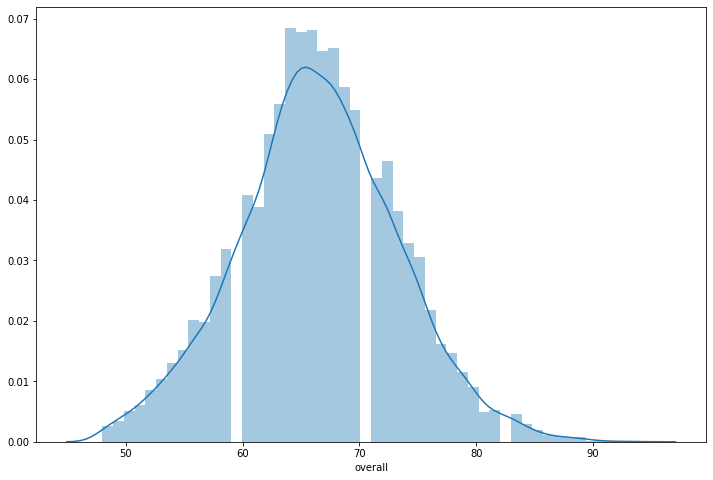

In [15]:
# EXAMINE THE DISTRIBUTION OF THE OVERALL RATINGS AND DETERMINE IF SCALING IS NEEDED
# WE CAN SEE THAT THE OVERALL RATINGS HAVE A NORMAL DISTRIBUTION THROUGHOUT THE PLAYERS
plt.figure(figsize=(12,8))
sns.distplot(df['overall'])

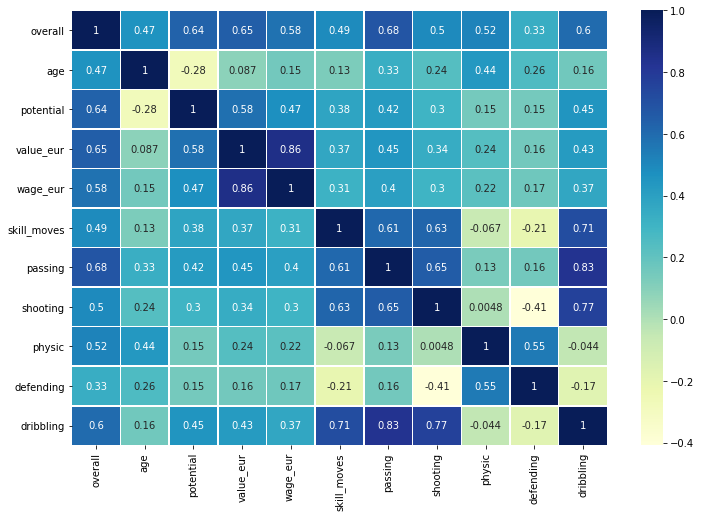

In [16]:
# CORRELATION ANALYSIS
# LOOK HOW EACH ATTRIBUTE FAIRS WITH THE OVERALL RATING
# VALUES ABOVE 0 INDICATE A POSITIVE CORRELATION AND VALUES BELOW 0 INDICATE NO CORRELATION
# WE CAN SEE THAT ALL ATTRIBUTES HAVE A POSITIVE CORRELATION WITH OVERALL RATING
cont_columns = ['overall','age','potential', 'value_eur','wage_eur','skill_moves','passing','shooting','physic','defending','dribbling']
corr = df[cont_columns].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr,cmap="YlGnBu",linewidths=.5,annot=True)

Text(0.5, 1.0, 'Overall Rating vs Player Potential')

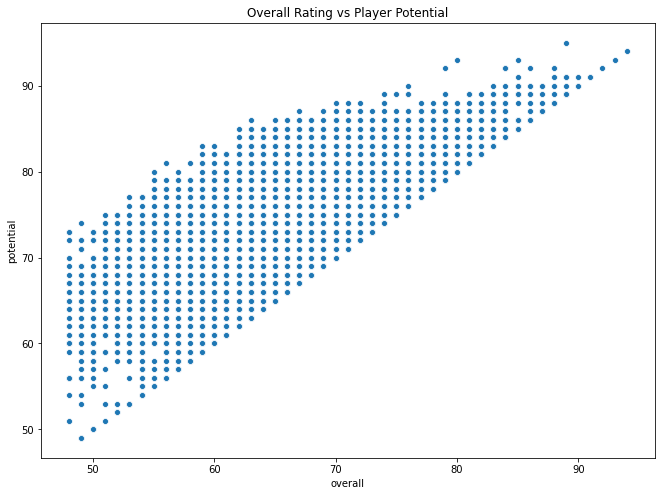

In [17]:
# CORRELATION BETWEEN OVERALL RATING AND POTENTIAL
# PLAYER POTENTIAL HAS A VERY LINEAR RELATIONSHIP WITH RATING
plt.figure(figsize=(11,8))
sns.scatterplot(x='overall',y='potential',data=df).set_title('Overall Rating vs Player Potential')

Text(0.5, 1.0, 'Overall Rating vs Player Value')

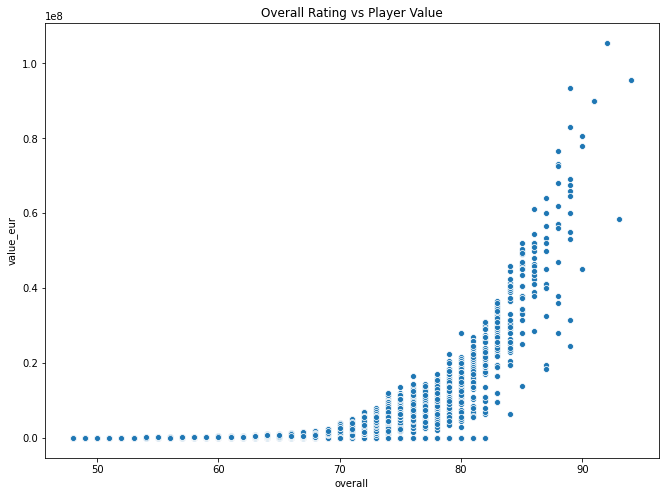

In [18]:
# CORRELATION BETWEEN OVERALL RATING AND PLAYER VALUE
# WE CAN SEE THAT PLAYER VALUE HAS A MORE EXPONENTIAL RELATIONSHIP WITH RATING
plt.figure(figsize=(11,8))
sns.scatterplot(x='overall',y='value_eur',data=df).set_title('Overall Rating vs Player Value')

Text(0.5, 1.0, 'Overall Rating vs Player Wage')

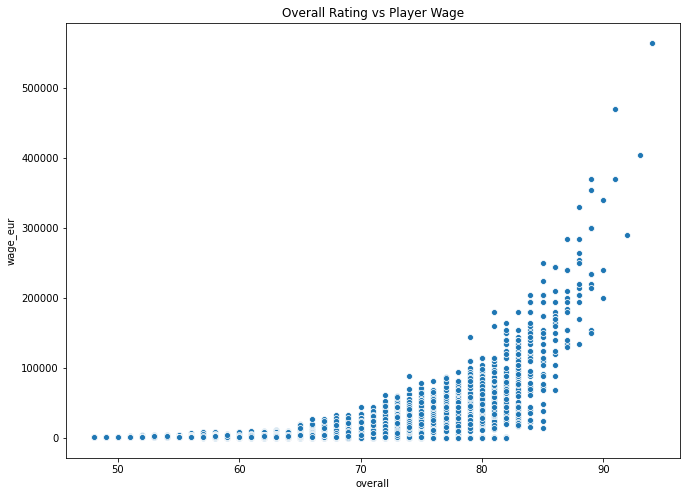

In [19]:
# CORRELATION BETWEEN OVERALL RATING AND PLAYER WAGE
# PLAYER WAGE ALSO HAS A EXPONENTIAL RELATIONSHIP WITH RATING
plt.figure(figsize=(11,8))
sns.scatterplot(x='overall',y='wage_eur',data=df).set_title('Overall Rating vs Player Wage')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x576 with 0 Axes>

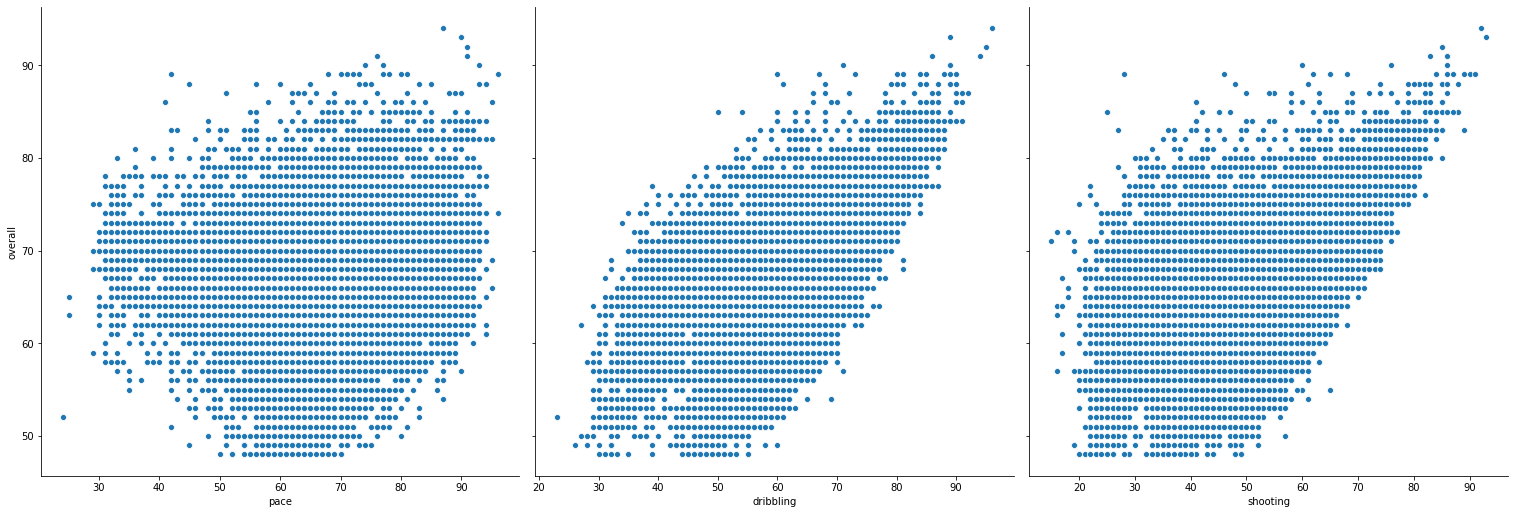

In [20]:
# CORRELATION WITH PACE, DRIBBLING AND SHOOTING TO OVERALL
plt.figure(figsize=(12,8))
sns.pairplot(df, x_vars=['pace','dribbling','shooting'], y_vars='overall', size=7, aspect=1)
# WE CAN SEE THAT DRIBBLING AND SHOOTING HAVE A LINEAR RELATIONSHIP WITH OVERALL RATING
# PACE HAS A MORE SPREAD OUT AND INDIRECT (BUT STILL POSITIVE) RELATIONSHIP

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x576 with 0 Axes>

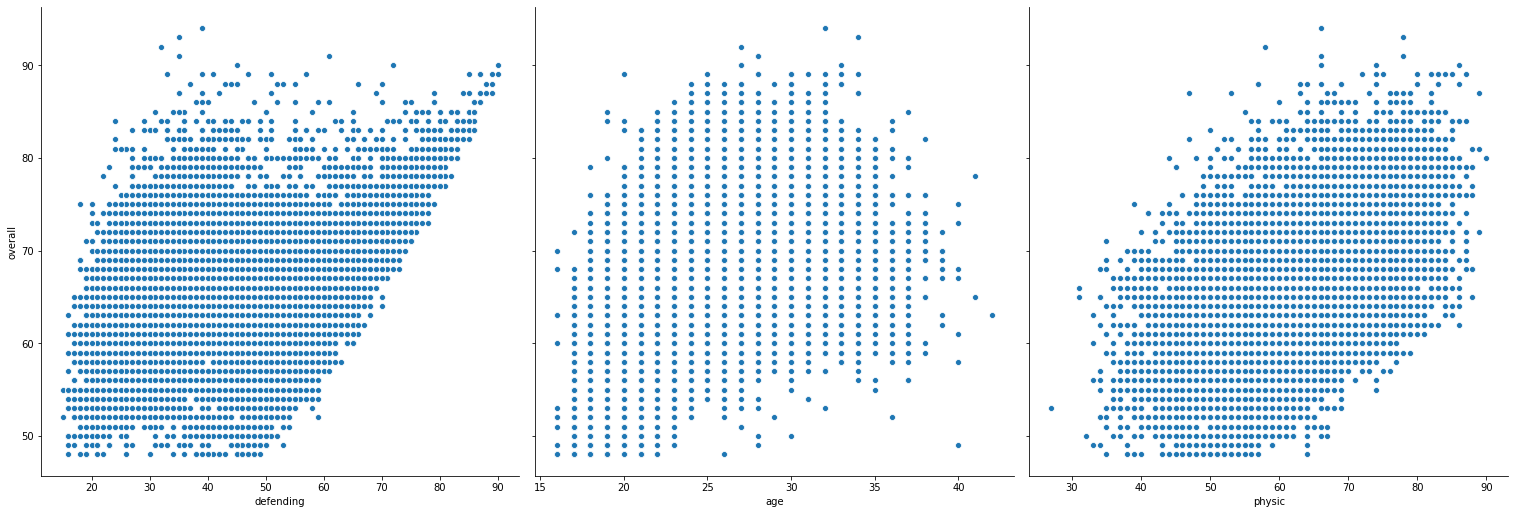

In [21]:
# CORRELATION WITH DEFENDING, AGE AND PHYSIC TO OVERALL
plt.figure(figsize=(12,8))
sns.pairplot(df, x_vars=['defending','age','physic'], y_vars='overall', size=7, aspect=1)
# DEFENDING AND PHYSICAL HAVE A LINEAR RELATIONSHIP WITH OVERALL RATING
# AGE HAS MORE OF A NORMAL DISTRIBUTION RELATIONSHIP WITH RATING

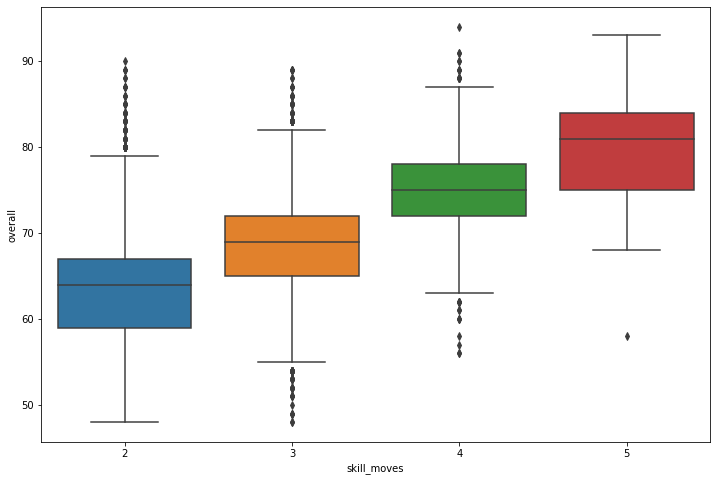

In [22]:
# CORRELATION BETWEEN OVERALL RATING AND SKILL MOVES
plt.figure(figsize=(12,8))
sns.boxplot(x = 'skill_moves', y = 'overall', data = df)
# SKIL MOVES ALSO SEEM TO HAVE A LINEAR RELATIONSHIP DESPITE THE AMOUNT OF OUTLIERS

In [23]:
# GROUP THE AVERAGE OVERALL RATINGS FOR EACH PLAYER POSITION
df_position_overall_avg = df.groupby([df['position']]).mean().overall
df_position_overall_avg = pd.DataFrame(df_position_overall_avg)
df_position_overall_avg=df_position_overall_avg.sort_values(['overall']).reset_index()

     position    overall
0     Reserve  61.460815
1  Substitute  65.421648
2     Defense  68.675828
3    Midfield  69.344200
4      Attack  70.438368


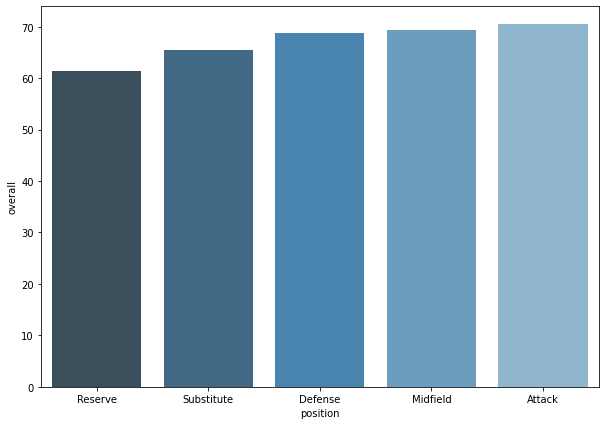

In [24]:
# PLOT THE AVERAGE OVERALL RATING FOR EACH POSITION TO SEE HOW THEY COMPARE

plt.figure(figsize=(10,7))
print(df_position_overall_avg)
sns.barplot(x = 'position',y='overall', data=df_position_overall_avg,palette="Blues_d")

In [25]:
# EXAMINE THE DISTRIBUTION OF PLAYER POSITIONS

df_position_freq = df['position'].value_counts().reset_index()
df_position_freq

,index,position
0,Substitute,6892
1,Defense,2656
2,Reserve,2552
3,Midfield,2362
4,Attack,1152


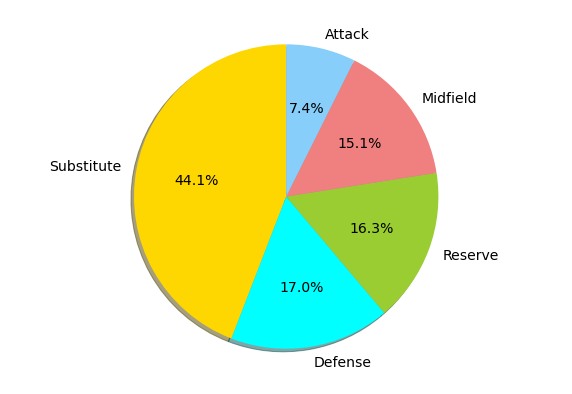

In [26]:
# LOOK AT THE PERCENTAGE DISTRIBUTION OF POSTIONS FOR THE PLAYERS
# MOST PLAYERS ARE SUBSTITUTES AND THE LEAST NUMBER OF PLAYERS ARER ATTACKERS
plt.figure(figsize=(10,7))
plt.axis('equal') 
colors = ['gold', 'cyan','yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(df_position_freq['position'], labels=df_position_freq['index'],autopct='%1.1f%%',
        shadow=True, startangle=90,colors=colors,textprops={'fontsize': 14})
plt.show()

In [27]:
########################################################################################
# This makes sense that there are mostly substitutes because the attack, midfield, 
# and defense positions all have average higher overall ratings because they are 
# more valuable players which is why they are playing and not a substitute or reserve.
########################################################################################

In [28]:
# DECIDE HOW TO HANDLE THE CATEGORICAL VARIABLES (LABEL ENCODING OR ONEHOT ENCODING)
# WE'LL USE ONEHOT ENCODING FOR THE POSITIONS
# FUNCTION TO APPLY ONEHOT ENCODING TO OUR CATEGORICAL VARIABLES
def onehot_encoding(dataframe,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    dataframe = pd.concat([dataframe,dummies],axis=1)
    return df

In [29]:
# APPLYING ONEHOT ENCODING TO PLAYERS POSITIN
df = onehot_encoding(df, "position")
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,position,position_Attack,position_Defense,position_Midfield,position_Reserve,position_Substitute
14860,223989,https://sofifa.com/player/223989/noor-husin/20...,N. Husin,Noor Husin,22,1997-03-03,178,65,Afghanistan,Stevenage,60,71,350000,2000,"CM, CDM",Right,1,2,2,Medium/Medium,Lean,No,683000.0,NaN,SUB,12.0,NaN,2019-08-01,2024.0,NaN,NaN,63.0,56.0,60.0,60.0,53.0,62.0,NaN,NaN,NaN,...,51,58,54,14,14,11,8,6,56+2,56+2,56+2,58+2,57+2,57+2,57+2,58+2,58+2,58+2,58+2,59+2,58+2,58+2,58+2,59+2,58+2,58+2,58+2,58+2,58+2,57+2,54+2,54+2,54+2,57+2,Substitute,0,0,0,0,1
11806,244175,https://sofifa.com/player/244175/hassan-amin/2...,H. Amin,Hassan Amin,27,1991-10-12,174,69,Afghanistan,SV Meppen,64,65,450000,1000,LB,Left,1,3,3,Medium/Medium,Lean,No,686000.0,NaN,LB,7.0,NaN,2018-07-01,2020.0,NaN,NaN,79.0,40.0,56.0,66.0,57.0,57.0,NaN,NaN,NaN,...,62,57,61,13,7,7,12,14,50+2,50+2,50+2,59+2,55+2,55+2,55+2,59+2,56+2,56+2,56+2,60+2,55+2,55+2,55+2,60+2,64+2,58+2,58+2,58+2,64+2,63+2,56+2,56+2,56+2,63+2,Defense,0,1,0,0,0
16134,228596,https://sofifa.com/player/228596/egli-kaja/20/...,E. Kaja,Egli Kaja,21,1997-07-26,177,78,Albania,AFC Wimbledon,58,67,200000,1000,"CAM, RM",Right,1,3,2,Medium/Medium,Normal,No,390000.0,NaN,RES,21.0,NaN,2015-04-17,2019.0,NaN,NaN,75.0,49.0,55.0,60.0,46.0,66.0,NaN,NaN,NaN,...,48,48,46,13,16,13,12,14,54+2,54+2,54+2,58+2,56+2,56+2,56+2,58+2,56+2,56+2,56+2,59+2,54+2,54+2,54+2,59+2,55+2,52+2,52+2,52+2,55+2,54+2,51+2,51+2,51+2,54+2,Reserve,0,0,0,1,0
18181,252556,https://sofifa.com/player/252556/brendon-shaba...,B. Shabani,Brendon Shabani,17,2001-10-22,182,72,Albania,Leyton Orient,49,69,60000,1000,CM,Left,1,3,2,Medium/Medium,Normal,No,165000.0,NaN,RES,28.0,NaN,2019-07-01,2021.0,NaN,NaN,65.0,43.0,47.0,50.0,39.0,49.0,NaN,NaN,NaN,...,42,38,36,14,12,15,14,13,45+2,45+2,45+2,49+2,47+2,47+2,47+2,49+2,49+2,49+2,49+2,49+2,47+2,47+2,47+2,49+2,46+2,45+2,45+2,45+2,46+2,45+2,41+2,41+2,41+2,45+2,Reserve,0,0,0,1,0
5080,202149,https://sofifa.com/player/202149/ergys-kace/20...,E. Kaçe,Ergys Kaçe,25,1993-07-08,170,62,Albania,PAOK,70,73,2200000,1000,"CM, CDM",Right,1,4,3,High/High,Lean,No,4800000.0,#Engine,SUB,26.0,NaN,2010-12-30,2020.0,NaN,NaN,75.0,65.0,66.0,70.0,70.0,72.0,NaN,NaN,NaN,...,72,73,66,7,16,15,8,12,64+2,64+2,64+2,67+2,66+2,66+2,66+2,67+2,67+2,67+2,67+2,68+2,69+2,69+2,69+2,68+2,71+2,71+2,71+2,71+2,71+2,70+2,68+2,68+2,68+2,70+2,Substitute,0,0,0,0,1


## 4. Choosing a Model
### Test the following Regression Models:
#### - Multiple Linear Regression
#### - Polynomial Regression

In [30]:
# PREPARE DATA BY IDENTIFYING FEATURES AND LABELS
feature_columns = ['age','potential', 'value_eur','wage_eur','skill_moves','passing','shooting','physic','defending','dribbling','position_Attack',	'position_Defense',	'position_Midfield',	'position_Reserve',	'position_Substitute']
X = df[feature_columns]
y = df.overall

In [31]:
# USE STANDARDSCALER TO SCALE OUR FEATURE DATA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [32]:
# DIVIDE DATA INTO TRAINING AND TESTING SETS WITH SCALER FOR BOTH X_TRAIN AND X_TEST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

## 5. Train the Models

In [33]:
# BEGIN TRAINING THE LINEAR REGRESSION MODEL
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
# BEGIN TRAINING THE POLYNOMIAL REGRESSION MODEL
from sklearn.preprocessing import PolynomialFeatures
lr_2 = LinearRegression()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
lr_2.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 6. Evaluate each Training Model using RSME and R^2 Score

In [35]:
# CALCULATING ACCURACY OF OUR LINEAR REGRESSION MODEL
train_eval = lr.predict(X_train)
mse = mean_squared_error(y_train, train_eval)

In [36]:
print("Linear Regression Summary:")
print("RSME for Training Set:",np.sqrt(mse))
print("R2 Score for Training Set:",r2_score(y_train,train_eval))

Linear Regression Summary:
RSME for Training Set: 2.007044812252114
R2 Score for Training Set: 0.9144987531822683


In [37]:
# CALCULATING ACCURACY OF OUR LINEAR REGRESSION MODEL
train_eval = lr_2.predict(X_train_poly)
mse = mean_squared_error(y_train, train_eval)

In [38]:
print("Polynomial Regression Summary:")
print("RSME for Training Set:",np.sqrt(mse))
print("R2 Score for Training Set:",r2_score(y_train,train_eval))

Polynomial Regression Summary:
RSME for Training Set: 1.007954745589052
R2 Score for Training Set: 0.9784354511329512


In [63]:
##############################################################################################

# Once we're happy with our accuracy on the training data, we can move onto the testing data.

##############################################################################################

## 7. Make Predictions

In [39]:
# USE LINEAR REGRESSION MODEL TO PREDICT OVERALL RATINGS FOR THE TESTING SET

linreg_predictions = lr.predict(X_test)
mse = mean_squared_error(y_test, linreg_predictions)
print("Linear Regression Summary:")
print("RSME for Testing Set:",np.sqrt(mse))
print("R2 Score for Testing Set:",r2_score(y_test,linreg_predictions))

Linear Regression Summary:
RSME for Testing Set: 2.0179678216216614
R2 Score for Testing Set: 0.910706732399105


In [40]:
# USE POLY REGRESSION MODEL TO PREDICT OVERALL RATINGS FOR THE TESTING SET

X_test_poly = poly.fit_transform(X_test)
polreg_predictions = lr_2.predict(X_test_poly)
mse = mean_squared_error(y_test, polreg_predictions)
print("Polynomial Regression Summary:")
print("RSME for Testing Set:",np.sqrt(mse))
print("R2 Score for Testing Set:",r2_score(y_test,polreg_predictions))

Polynomial Regression Summary:
RSME for Testing Set: 1.009310902475225
R2 Score for Testing Set: 0.9776622116671051


In [41]:
# CREATE DATAFRAME OF PREDICTIONS FROM EACH MODEL TO EACH ACTUAL RATING
df_compare = pd.DataFrame(y_test.values, columns =['Actual']) 
df_compare['LinReg Predicts'] = linreg_predictions
df_compare['PolyReg Predicts'] = polreg_predictions
df_compare.head(10)

,Actual,LinReg Predicts,PolyReg Predicts
0,63,61.126234,62.275537
1,76,75.935273,76.362658
2,63,62.940087,63.334047
3,57,56.781343,57.341753
4,67,69.606554,69.948664
5,75,76.265267,75.869341
6,72,71.876707,71.422991
7,75,75.486499,75.375200
8,68,63.713266,66.650652
9,87,90.334693,88.717119


# Predict Player Ratings for FIFA 21

### Data Extraction and Cleaning


In [42]:
feature_columns = ['age','potential', 'value_eur','wage_eur','skill_moves','passing','shooting','physic','defending','dribbling','position_Attack',	'position_Defense',	'position_Midfield',	'position_Reserve',	'position_Substitute']
cont_feature_len = len(feature_columns)-4 # NUMBER OF CONTINUOUS FEATURES, WILL BE USED FOR INDEXING LATER ON

In [43]:
# ELIMINATE GOALKEEPERS
# IDENTIFY THE TOP 10 PLAYERS FROM FIFA 20 AND SORT THEM BY NAME
df_20=df_20[df_20['team_position']!='GK']
fifa20_top10 = df_20.head(10).sort_values(by=['short_name'])

In [44]:
# REPEAT THE SAME PROCESS AS BEFORE TO ENCODE THE POSITION FOR EACH PLAYER
# SINCE NO PLAYER IN THE TOP10 IS A SUBSTITUTE OR RESERVE, PLACE ZEROS IN PLACE

position_label=[]
reserve_label=[]
substitute_label=[]
for row in fifa20_top10['team_position']:
  reserve_label.append(0)
  substitute_label.append(0)
  if row in attack_positions:
    label = 'Attack'
  elif row in midfield_positions:
    label = 'Midfield'
  elif row in defense_positions:
    label = 'Defense'
  else:
    label = None
  position_label.append(label)

In [45]:
# DF_POSITION IS THE DATAFRAME OF THE ENCODED POSITIONS
# WILL APPEND THIS TO THE FINAL DATAFRAME OF THE PREDICTED PLAYER STATS

df_position = pd.DataFrame(position_label, columns=['position'])
df_position = onehot_encoding(df_position, "position")
df_position['position_Reserve'] = reserve_label
df_position['position_Substitute'] = substitute_label

In [46]:
# LIST OF TOP 10 PLAYERS
# NEYMAR IS ADDED BECAUSE HIS NAME IS DIFFERENT IN OLDER VERSIONS OF FIFA
top_10_players = fifa20_top10['short_name'].values.tolist()
top_10_players.append('Neymar')

In [47]:
# EXTRACT THE TOP 10 PLAYERS AND THEIR STATISTICS FROM OLDER FIFA DATASETS
fifa19_top10 = df_19[df_19['short_name'].isin(top_10_players)]
fifa18_top10 = df_18[df_18['short_name'].isin(top_10_players)]

In [48]:
# EXTRACT ONLY THE CONTINUOUS FEATURE COLUMNS THAT WE WANT TO USE
# INCLUDE PLAYER NAME FOR EASIER VISUALIZATION
feature_columns.insert(0,'short_name')
fifa20_top10=fifa20_top10[feature_columns[:cont_feature_len]].reset_index(drop=True)
fifa19_top10=fifa19_top10[feature_columns[:cont_feature_len]].sort_values(by=['short_name']).reset_index(drop=True)
fifa18_top10=fifa18_top10[feature_columns[:cont_feature_len]].sort_values(by=['short_name']).reset_index(drop=True)
fifa18_top10=fifa18_top10.replace('Neymar', 'Neymar Jr') # REPLACE NEYMAR WITH NEYMAR JR IN FIFA 18 DATASET
top_10_players.remove('Neymar') # ONCE REPLACES, WE CAN REMOVE NEYMAR FROM THE LIST OF TOP 10 PLAYERS

In [49]:
fifa20_top10

,short_name,age,potential,value_eur,wage_eur,skill_moves,passing,shooting,physic,defending,dribbling
0,Cristiano Ronaldo,34,93,58500000,405000,5,82.0,93.0,78.0,35.0,89.0
1,E. Hazard,28,91,90000000,470000,4,86.0,83.0,66.0,35.0,94.0
2,K. De Bruyne,28,91,90000000,370000,4,92.0,86.0,78.0,61.0,86.0
3,K. Koulibaly,28,91,67500000,150000,2,54.0,28.0,87.0,89.0,67.0
4,K. Mbappé,20,95,93500000,155000,5,78.0,84.0,75.0,39.0,90.0
5,L. Messi,32,94,95500000,565000,4,92.0,92.0,66.0,39.0,96.0
6,L. Modrić,33,90,45000000,340000,4,89.0,76.0,66.0,72.0,89.0
7,M. Salah,27,90,80500000,240000,4,81.0,86.0,74.0,45.0,89.0
8,Neymar Jr,27,92,105500000,290000,5,87.0,85.0,58.0,32.0,95.0
9,V. van Dijk,27,91,78000000,200000,2,70.0,60.0,86.0,90.0,71.0


In [50]:
fifa19_top10.head()

,short_name,age,potential,value_eur,wage_eur,skill_moves,passing,shooting,physic,defending,dribbling
0,Cristiano Ronaldo,33,94,77000000,405000,5,81.0,93.0,79.0,35.0,89.0
1,E. Hazard,27,91,93000000,340000,4,86.0,82.0,67.0,35.0,94.0
2,K. De Bruyne,27,92,102000000,355000,4,92.0,86.0,78.0,60.0,87.0
3,K. Koulibaly,27,90,51000000,115000,2,46.0,26.0,86.0,88.0,59.0
4,K. Mbappé,19,95,72000000,83000,5,79.0,81.0,72.0,39.0,89.0


In [51]:
fifa18_top10.tail()

,short_name,age,potential,value_eur,wage_eur,skill_moves,passing,shooting,physic,defending,dribbling
5,L. Messi,30,93,105000000,565000,4,86.0,90.0,61.0,26.0,96.0
6,L. Modrić,31,89,57000000,340000,4,86.0,75.0,65.0,72.0,89.0
7,M. Salah,25,86,32500000,135000,4,74.0,73.0,66.0,45.0,87.0
8,Neymar Jr,25,94,123000000,280000,5,79.0,84.0,60.0,30.0,95.0
9,V. van Dijk,25,86,27500000,89000,2,67.0,60.0,85.0,83.0,69.0


In [52]:
fifa20_stats = fifa20_top10.iloc[:,1:cont_feature_len]
fifa19_stats = fifa19_top10.iloc[:,1:cont_feature_len]
fifa18_stats = fifa18_top10.iloc[:,1:cont_feature_len]

### Predict Individual Player Statistics


In [53]:
# FUNCTION TO CALCULATE THE A PLAYERS PREDICTED STATISTIC
# GRABS THAT INDIVIDUAL STAT FROM EACH FIFA VERSION
# RETURNS THE FINAL PREDICTED VALUE
def project_stat(player, feature):
  stat_20 = fifa20_top10[fifa20_top10['short_name']==player]
  stat_20 = stat_20[feature].values
  stat_19 = fifa19_top10[fifa19_top10['short_name']==player]
  stat_19 = stat_19[feature].values
  stat_18 = fifa18_top10[fifa18_top10['short_name']==player]
  stat_18 = stat_18[feature].values
  stat_dif_20_19 = stat_20-stat_19
  stat_dif_19_18 = stat_19-stat_18
  new_stat = (((stat_dif_20_19*1.4) + (stat_dif_19_18*.6))/2)+ stat_20
  return float(new_stat)

In [54]:
# EMPTY LISTS TO STORE THE PREDICTED PLAYER STATS
predicted_potential=[]
predicted_value=[]
predicted_wage=[]
predicted_skill_moves=[]
predicted_passing=[]
predicted_shooting=[]
predicted_physic=[]
predicted_defending=[]
predicted_dribbling=[]

In [55]:
# ITERATES THROUGH THE TOP 10 PLAYERS AND CALLS THE PROJECT_STAT FUNCTION ON EACH FEATURE
# THE PREDICTED STAT IS THEN APPENDED TO THE EMPTY ARRAYS ABOVE

for player in fifa20_top10[:10].iterrows():
  player_index = player[1][0]
  predicted_potential.append(project_stat(player_index, player[1].index[2]))
  predicted_value.append(project_stat(player_index, player[1].index[3]))
  predicted_wage.append(project_stat(player_index, player[1].index[4]))
  predicted_skill_moves.append(project_stat(player_index, player[1].index[5]))
  predicted_passing.append(project_stat(player_index, player[1].index[6]))
  predicted_shooting.append(project_stat(player_index, player[1].index[7]))
  predicted_physic.append(project_stat(player_index, player[1].index[8]))
  predicted_defending.append(project_stat(player_index, player[1].index[9]))
  predicted_dribbling.append(project_stat(player_index, player[1].index[10]))

In [56]:
# CREATE DATAFRAME OF EACH PLAYER AND THEIR PREDICTED FIFA 21 STATS

list_of_tuples = list(zip(top_10_players[:10], fifa20_top10['age']+1,predicted_potential,predicted_value,predicted_wage,
                          predicted_skill_moves,predicted_passing,predicted_shooting,predicted_physic,predicted_defending,predicted_dribbling))
df_predicted = pd.DataFrame(list_of_tuples, columns = feature_columns[:cont_feature_len])
df_predicted = pd.concat([df_predicted, df_position], axis=1, sort=False) # COMBINE THE PLAYER POSITION DATAFRAME

In [57]:
df_predicted

,short_name,age,potential,value_eur,wage_eur,skill_moves,passing,shooting,physic,defending,dribbling,position,position_Attack,position_Defense,position_Midfield,position_Reserve,position_Substitute
0,Cristiano Ronaldo,35,92.3,40000000.0,357000.0,5.0,82.4,93.0,77.0,35.6,88.7,Attack,1,0,0,0,0
1,E. Hazard,29,91.0,88650000.0,574500.0,4.0,86.6,83.7,65.6,35.9,94.6,Attack,1,0,0,0,0
2,K. De Bruyne,29,90.3,87300000.0,401500.0,4.0,93.2,86.6,78.9,66.2,85.9,Midfield,0,0,1,0,0
3,K. Koulibaly,29,92.6,84600000.0,180200.0,2.0,60.5,29.4,87.7,90.6,73.5,Defense,0,1,0,0,0
4,K. Mbappé,21,95.3,117700000.0,221000.0,5.3,78.8,86.4,76.5,36.6,91.9,Attack,1,0,0,0,0
5,L. Messi,33,94.3,86650000.0,565000.0,4.0,95.4,93.0,69.5,45.7,96.0,Attack,1,0,0,0,0
6,L. Modrić,34,89.9,32600000.0,308000.0,4.0,89.5,76.3,65.9,72.8,88.2,Midfield,0,0,1,0,0
7,M. Salah,28,91.6,99300000.0,265500.0,4.0,83.9,90.7,77.2,45.0,89.6,Attack,1,0,0,0,0
8,Neymar Jr,28,91.0,95050000.0,293000.0,5.0,91.0,85.7,57.0,32.6,95.0,Attack,1,0,0,0,0
9,V. van Dijk,28,94.1,108950000.0,253300.0,2.0,72.1,60.0,87.1,94.1,72.0,Defense,0,1,0,0,0


### Make Predictions

In [58]:
# LIMIT THE DATAFRAME TO JUST THE SPECIFIC FEATURE COLUMS WE WANT TO USE
# APPLY THE SAME SCALER FROM BEFORE

fifa21_test = df_predicted[feature_columns[1:]]
fifa21_test=scaler.transform(fifa21_test)

In [59]:
# PREDICT PLAYER RATINGS USING MULTIPLE LINEAR REGRESSION

fifa21_lr_predictions = lr.predict(fifa21_test)

In [60]:
# PREDICT PLAYER RATINGS USING POLYNOMIAL REGRESSION

fifa21_test_poly = poly.fit_transform(fifa21_test)
fifa21_pr_predictions = lr_2.predict(fifa21_test_poly)

In [61]:
# CREATE FINAL DATAFRAME OF ALL THE ACTUAL OVERALL RATINGS AND THE PREDICTED RATINGS

fifa21_overall = df_20[['short_name','overall']].head(10).sort_values('short_name').reset_index(drop=True)
fifa21_overall=fifa21_overall.rename(columns={"overall": "Fifa20 Rating"})
fifa21_overall['Fifa21 LR Rating'] = fifa21_lr_predictions
fifa21_overall['Fifa21 PR Rating'] = fifa21_pr_predictions

In [62]:
# FINAL GLANCE AT THE PREDICTED OVERALL RATINGS

fifa21_overall

,short_name,Fifa20 Rating,Fifa21 LR Rating,Fifa21 PR Rating
0,Cristiano Ronaldo,93,96.830596,91.659571
1,E. Hazard,91,97.659261,98.345140
2,K. De Bruyne,91,98.771641,92.282198
3,K. Koulibaly,89,99.024676,84.383135
4,K. Mbappé,89,102.551678,93.851572
5,L. Messi,94,103.205993,91.589899
6,L. Modrić,90,92.142441,88.436373
7,M. Salah,90,101.372426,88.913599
8,Neymar Jr,92,98.690834,91.631636
9,V. van Dijk,90,103.421018,88.735308
